<a href="https://colab.research.google.com/github/paulatoledo30/BCC325/blob/main/praticaIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

housing = pd.read_csv('./housing.csv')
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


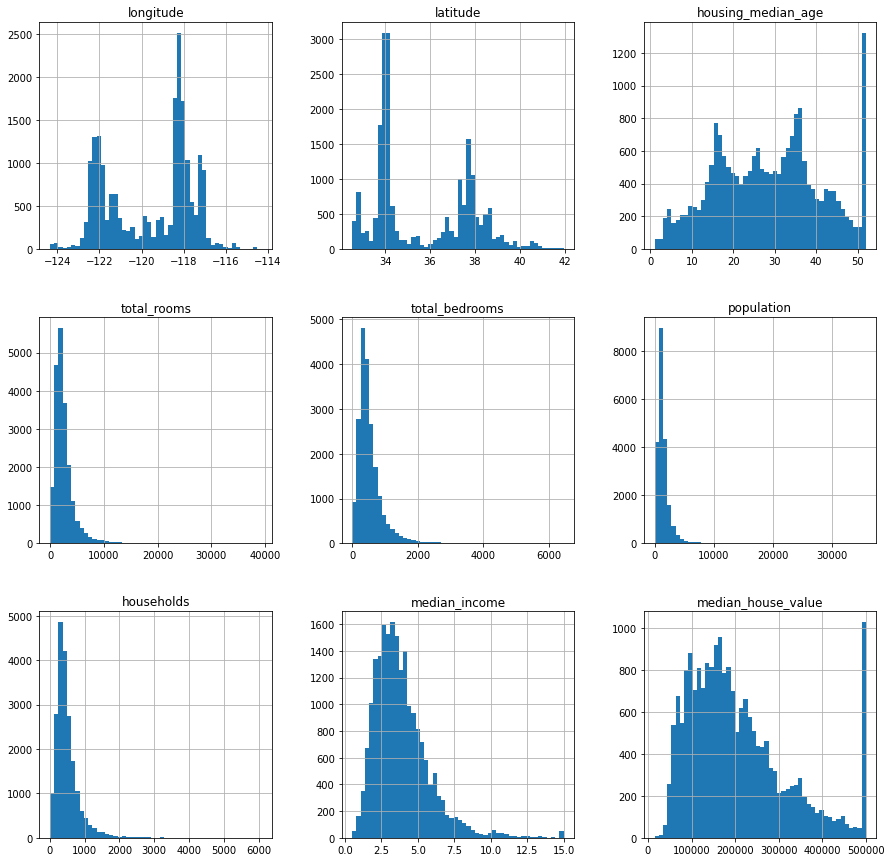

In [ ]:
housing.hist(bins=50, figsize=(15,15))
plt.show()

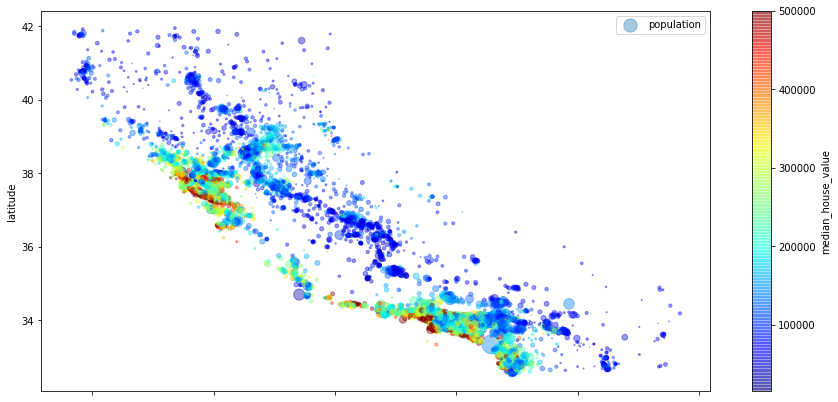

In [ ]:
housing["income_cat"] = np.ceil(housing["median_income"]/ 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
strat_train_set.drop(["income_cat"], axis=1, inplace=True)
strat_test_set.drop(["income_cat"], axis=1, inplace=True)
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7))
plt.legend()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f270756b9d0>,
      dtype=object)

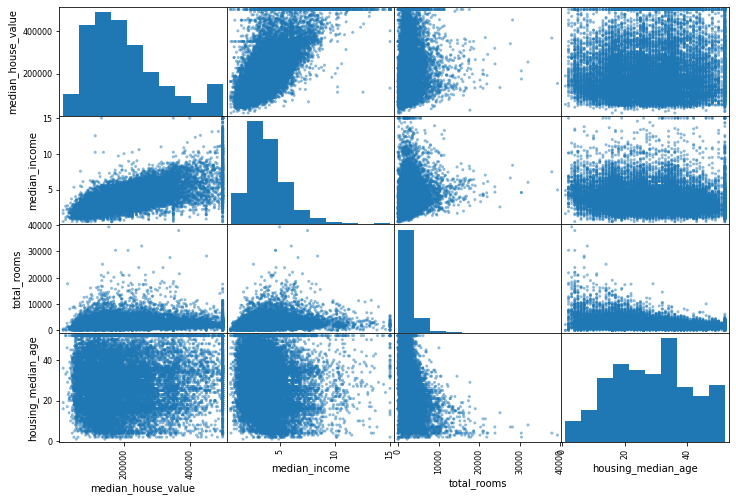

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income',
             'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

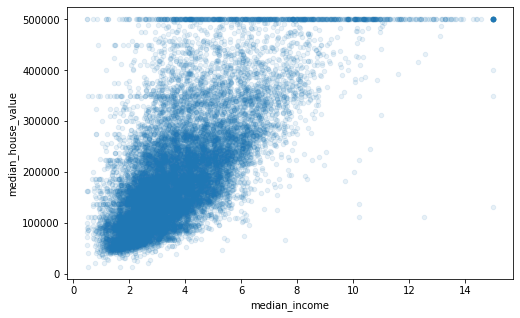

In [ ]:
housing.plot(kind='scatter', x='median_income', y='median_house_value',
            alpha=0.1, figsize=(8,5))

In [ ]:
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN


In [ ]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974


In [ ]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop('ocean_proximity', axis=1)
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
# this component gives us the flexibility to add extra attributes to our pipeline
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
# this component allows us to select entire or partial dataframe
# or in simpler words we can tell which attributes we want in our pipeline
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):return self
    
    def transform(self, X):return X[self.attribute_names].values

class MyLabelBinarizer(TransformerMixin):
    
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    
    def transform(self, x, y=0):return self.encoder.transform(x)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelBinarizer

# our numerical pipeline
num_pipeline = Pipeline([
                    ('selector', DataFrameSelector(num_attribs)),
                    ('imputer', SimpleImputer(strategy="median")),
                    ('attribs_adder', CombinedAttributesAdder()),
                    ('std_scaler', StandardScaler()),
                ])

# our categorical pipeline
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', MyLabelBinarizer()),
])

# our full pipeline
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

# find root mean squared error, scores is an array of negative numbers
rmse_scores = np.sqrt(-scores)

print("Mean:\t\t ", rmse_scores.mean(), "\nStandard Deviation:", rmse_scores.std())

Mean:		  69052.46136345083 
Standard Deviation: 2731.674001798344


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
# see the 10 scores
scores

array([-4.95027087e+09, -4.59718682e+09, -4.96606151e+09, -4.71836699e+09,
       -4.85498504e+09, -5.54883526e+09, -5.03498483e+09, -5.00632748e+09,
       -5.96482125e+09, -4.89781924e+09])

In [ ]:
# find root mean squared error
rmse_scores = np.sqrt(-scores)
print("Mean:\t\t ", rmse_scores.mean(), "\nStandard Deviation:", rmse_scores.std())

Mean:		  71041.93143306968 
Standard Deviation: 2647.622722952548


In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Mean:\t\t ", forest_rmse_scores.mean(), "\nStandard Deviation:", forest_rmse_scores.std())

Mean:		  50196.95149063779 
Standard Deviation: 1947.0966773063687


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
print("{}\t\t {}\n".format('Mean Score','Parameters'))
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    x = np.sqrt(-mean_score)
    y = params
    print("{:.2f}\t {}".format(x, y))

Mean Score		 Parameters

64418.97	 {'max_features': 2, 'n_estimators': 3}
55407.19	 {'max_features': 2, 'n_estimators': 10}
53099.33	 {'max_features': 2, 'n_estimators': 30}
60616.30	 {'max_features': 4, 'n_estimators': 3}
53071.59	 {'max_features': 4, 'n_estimators': 10}
50449.85	 {'max_features': 4, 'n_estimators': 30}
58456.39	 {'max_features': 6, 'n_estimators': 3}
52051.20	 {'max_features': 6, 'n_estimators': 10}
50009.69	 {'max_features': 6, 'n_estimators': 30}
57736.84	 {'max_features': 8, 'n_estimators': 3}
52557.45	 {'max_features': 8, 'n_estimators': 10}
50009.53	 {'max_features': 8, 'n_estimators': 30}
62132.46	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54827.82	 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59138.63	 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52447.23	 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58708.41	 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51966.48	 {'bootstrap': False, '

In [ ]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
# we prepare the data
X_test_prepared = full_pipeline.transform(X_test)

# do the prediction
final_predictions = final_model.predict(X_test_prepared)

# find mean square error
final_mse = mean_squared_error(y_test, final_predictions)
# find root mean square error
final_rmse = np.sqrt(final_mse)
final_rmse

47852.23301226073